# Surgery Duration Prediction: Production Model Analysis (No Data Leakage)

**Objective:** Build and optimize a production-ready CATBOOST model to compare against other models.

---

## Executive Summary

This notebook systematically:
1. Trains baseline model
2. Diagnoses heteroscedasticity on honest baseline
3. Tests all solutions on production features

---

## Table of Contents

1. [Setup & Data Loading](#section-1)
2. [Production Baseline Model (No Planned Duration)](#section-2)
3. [Heteroscedasticity Diagnosis](#section-3)
4. [Solution 1: Sample Weighting](#section-4)
5. [Solution 2: Alternative Loss Functions](#section-5)
6. [Solution 3: Box-Cox Transformation](#section-6)
7. [Solution 4: Two-Stage Modeling](#section-7)
8. [Solution 5: Quantile Regression](#section-8)
9. [Solution 6: Hyperparameter Optimization](#section-9)
10. [Final Comparison & Recommendation](#section-10)

---
<a id='section-1'></a>
## 1. Setup & Data Loading

In [1]:
print("="*80)
print("SECTION 1: SETUP & IMPORTS")
print("="*80)

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import json
import os
from copy import deepcopy
warnings.filterwarnings('ignore')

# ML libraries
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import boxcox, skew, pearsonr
from scipy.special import inv_boxcox

# Hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully")
print(f"Random seed set to: {RANDOM_SEED}")

SECTION 1: SETUP & IMPORTS
✅ All libraries imported successfully
Random seed set to: 42


In [2]:
print("\n" + "="*80)
print("DATA LOADING & INITIAL PREPROCESSING")
print("="*80)

# Load your data
data = pd.read_csv("/Users/joshlim/Documents/GitHub/BT4103-OPTIC/Data/Preprocessed_Dataset.csv")

print(f"Dataset shape: {data.shape}")
print(f"Target variable: ACTUAL_SURGERY_DURATION")

# Define target
target_col = 'ACTUAL_SURGERY_DURATION'

exclude_features = [
    'OPERATION_ID',  # Just an ID
    'PATIENT_CODE',  # Identifier 
    'ACTUAL_SURGERY_DURATION',  # Target
    'ACTUAL_USAGE_DURATION',  # Likely data leakage
    'Delay_Reason',
    'Delay_Category',
    'PLANNED_USAGE_DURATION',
    'PLANNED_SURGERY_DURATION',
]

print("\n" + "="*80)
print("PRODUCTION MODE: PLANNED DURATION FEATURES EXCLUDED")
print("="*80)
print("Excluded features:")
for feat in exclude_features:
    if feat in data.columns:
        print(f"  ✓ {feat}")
    else:
        print(f"  - {feat} (not in data)")

# Categorical features
categorical_features = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 
    'EMERGENCY_PRIORITY', 'SURGICAL_CODE', 'DISCIPLINE', 
    'SURGEON', 'ANAESTHETIST_TEAM', 'ANAESTHETIST_MCR_NO',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS',
    'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE', 'ADMISSION_WARD',
    'ADMISSION_BED', 'BLOOD', 'IMPLANT', 'DIAGNOSIS'
]

# Get production features
feature_cols = [col for col in data.columns if col not in exclude_features]
categorical_features = [col for col in categorical_features if col in feature_cols]

print(f"\nTotal production features: {len(feature_cols)}")
print(f"Categorical features: {len(categorical_features)}")

# Data quality checks
print("\n" + "-"*80)
print("DATA QUALITY CHECKS")
print("-"*80)
print(f"Missing values in target: {data[target_col].isna().sum()}")
print(f"\nTarget statistics:")
print(data[target_col].describe())
print(f"\nSkewness: {skew(data[target_col]):.3f}")
print(f"(Positive skew indicates right tail - longer surgeries are rarer)")


DATA LOADING & INITIAL PREPROCESSING
Dataset shape: (247613, 41)
Target variable: ACTUAL_SURGERY_DURATION

🚨 PRODUCTION MODE: PLANNED DURATION FEATURES EXCLUDED
Excluded features:
  ✓ OPERATION_ID
  ✓ PATIENT_CODE
  ✓ ACTUAL_SURGERY_DURATION
  ✓ ACTUAL_USAGE_DURATION
  ✓ Delay_Reason
  ✓ Delay_Category
  ✓ PLANNED_USAGE_DURATION
  ✓ PLANNED_SURGERY_DURATION

Total production features: 33
Categorical features: 20

--------------------------------------------------------------------------------
DATA QUALITY CHECKS
--------------------------------------------------------------------------------
Missing values in target: 0

Target statistics:
count    247613.000000
mean         58.466902
std          73.258195
min           0.000000
25%          16.000000
50%          33.000000
75%          71.000000
max         967.000000
Name: ACTUAL_SURGERY_DURATION, dtype: float64

Skewness: 3.169
(Positive skew indicates right tail - longer surgeries are rarer)


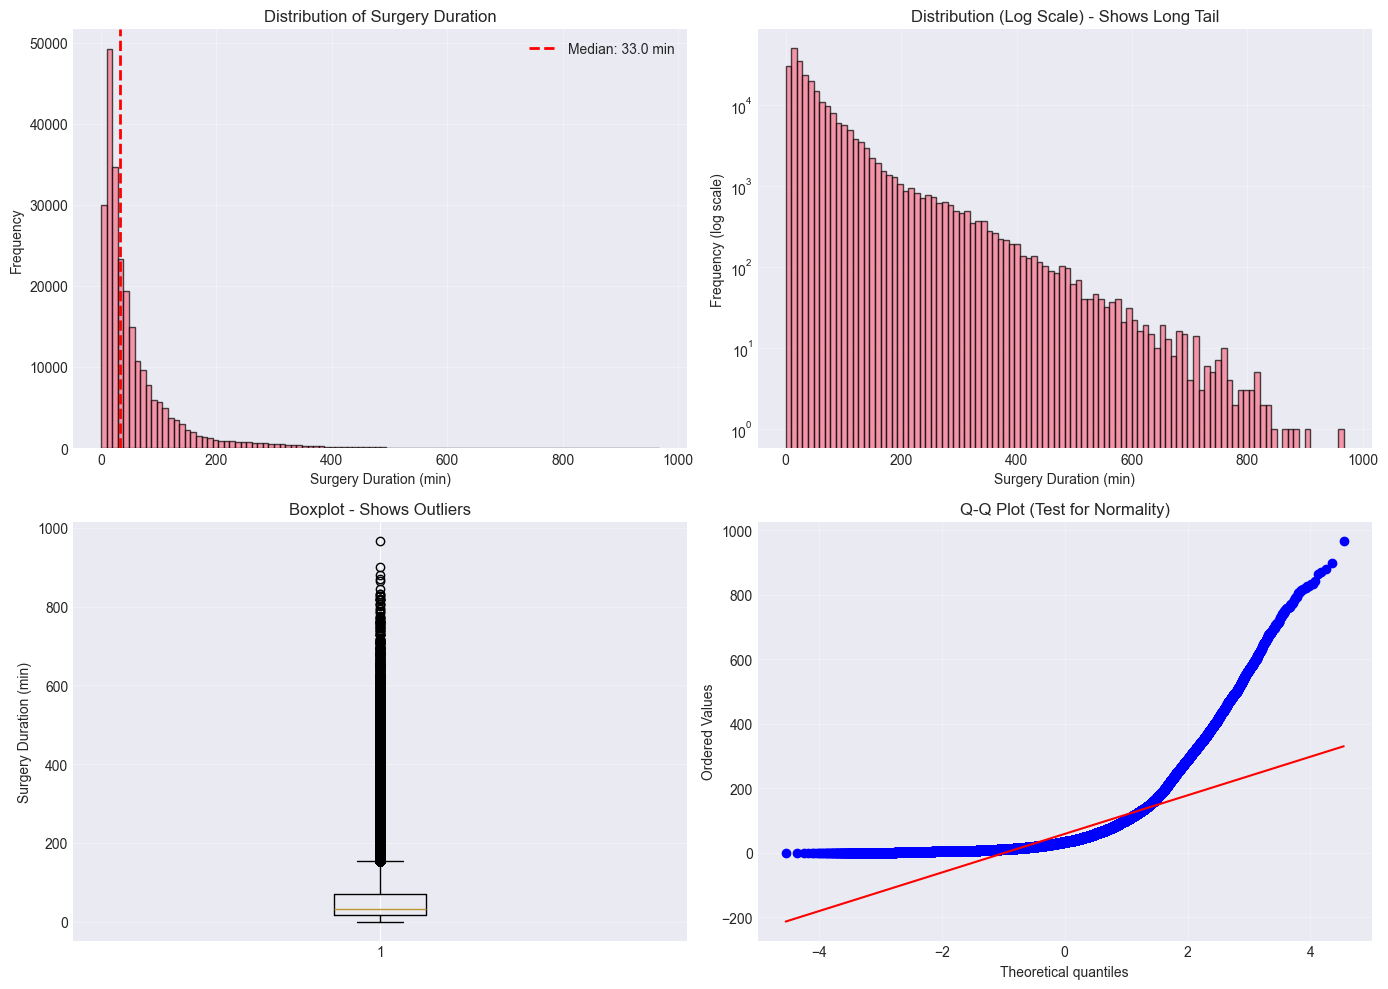


🔍 Key Observations:
  • Distribution is right-skewed (long tail of extended surgeries)
  • Q-Q plot shows departure from normality
  • This skewness contributes to heteroscedasticity


In [3]:
# Visualize target distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(data[target_col], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Surgery Duration (min)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Surgery Duration')
axes[0, 0].axvline(data[target_col].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {data[target_col].median():.1f} min')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Log-scale histogram
axes[0, 1].hist(data[target_col], bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Surgery Duration (min)')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Distribution (Log Scale) - Shows Long Tail')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot
axes[1, 0].boxplot(data[target_col], vert=True)
axes[1, 0].set_ylabel('Surgery Duration (min)')
axes[1, 0].set_title('Boxplot - Shows Outliers')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Q-Q plot for normality
stats.probplot(data[target_col], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Test for Normality)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  • Distribution is right-skewed (long tail of extended surgeries)")
print("  • Q-Q plot shows departure from normality")
print("  • This skewness contributes to heteroscedasticity")

In [5]:
# Train/Val/Test split
print("\n" + "="*80)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*80)

X = data[feature_cols]
y = data[target_col]

print(f"Total features: {len(feature_cols)}")

# 70/10/20 split
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))

X_train = X.iloc[:train_size]
X_val = X.iloc[train_size:train_size+val_size]
X_test = X.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]

print(f"\nTrain set: {len(X_train):,} samples ({len(X_train)/len(data)*100:.1f}%)")
print(f"Val set:   {len(X_val):,} samples ({len(X_val)/len(data)*100:.1f}%)")
print(f"Test set:  {len(X_test):,} samples ({len(X_test)/len(data)*100:.1f}%)")

print(f"\nTarget statistics by split:")
print(f"Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}, median={y_train.median():.2f}")
print(f"Val:   mean={y_val.mean():.2f}, std={y_val.std():.2f}, median={y_val.median():.2f}")
print(f"Test:  mean={y_test.mean():.2f}, std={y_test.std():.2f}, median={y_test.median():.2f}")

# Create CatBoost pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

print("\nData splits and CatBoost pools created")


TRAIN/VALIDATION/TEST SPLIT
Total features: 33

Train set: 173,329 samples (70.0%)
Val set:   24,761 samples (10.0%)
Test set:  49,523 samples (20.0%)

Target statistics by split:
Train: mean=58.20, std=72.87, median=33.00
Val:   mean=60.10, std=74.61, median=34.00
Test:  mean=58.59, std=73.92, median=33.00

✅ Data splits and CatBoost pools created


---
<a id='section-2'></a>
## 2. Production Baseline Model (No Planned Duration)

**CRITICAL:** This baseline is trained WITHOUT planned duration features.

All predictions are honest and production-ready from the start.

In [6]:
print("="*80)
print("SECTION 2: PRODUCTION BASELINE MODEL")
print("="*80)
print("\nTraining WITHOUT planned duration features")
print("   This is your TRUE baseline for production deployment\n")

# Train baseline model
print("Training production baseline CatBoost model...")
baseline_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8, 
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=200
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# Get predictions
train_preds_baseline = baseline_model.predict(X_train)
val_preds_baseline = baseline_model.predict(X_val)
test_preds_baseline = baseline_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_preds_baseline)
val_mae = mean_absolute_error(y_val, val_preds_baseline)
test_mae = mean_absolute_error(y_test, test_preds_baseline)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds_baseline))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds_baseline))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds_baseline))

train_r2 = r2_score(y_train, train_preds_baseline)
val_r2 = r2_score(y_val, val_preds_baseline)
test_r2 = r2_score(y_test, test_preds_baseline)

print(f"\n{'='*80}")
print("PRODUCTION BASELINE RESULTS (No Planned Duration)")
print(f"{'='*80}")
print(f"{'Split':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
print("-"*80)
print(f"{'Train':<10} {train_mae:<12.2f} {train_rmse:<12.2f} {train_r2:<12.4f}")
print(f"{'Val':<10} {val_mae:<12.2f} {val_rmse:<12.2f} {val_r2:<12.4f}")
print(f"{'Test':<10} {test_mae:<12.2f} {test_rmse:<12.2f} {test_r2:<12.4f}")

print("\nThis is your HONEST baseline for production deployment")

# Store baseline results for comparison
results_tracker = {
    'Production_Baseline': {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'model': baseline_model,
        'predictions': test_preds_baseline
    }
}

SECTION 2: PRODUCTION BASELINE MODEL

🚨 Training WITHOUT planned duration features
   This is your TRUE baseline for production deployment

Training production baseline CatBoost model...
0:	learn: 41.0757372	test: 42.2457625	best: 42.2457625 (0)	total: 178ms	remaining: 5m 55s
200:	learn: 22.0264076	test: 22.5419998	best: 22.5419998 (200)	total: 26.2s	remaining: 3m 54s
400:	learn: 21.1924144	test: 21.8365708	best: 21.8365708 (400)	total: 55.2s	remaining: 3m 40s
600:	learn: 20.6828949	test: 21.4695901	best: 21.4695901 (600)	total: 1m 23s	remaining: 3m 15s
800:	learn: 20.3442748	test: 21.2511314	best: 21.2511314 (800)	total: 1m 52s	remaining: 2m 48s
1000:	learn: 20.1064285	test: 21.1408470	best: 21.1408470 (1000)	total: 2m 20s	remaining: 2m 20s
1200:	learn: 19.9263974	test: 21.0775347	best: 21.0774330 (1199)	total: 2m 49s	remaining: 1m 52s
1400:	learn: 19.7702014	test: 21.0311058	best: 21.0311058 (1400)	total: 3m 17s	remaining: 1m 24s
1600:	learn: 19.6297567	test: 20.9923905	best: 20.9923


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
             feature  importance
       SURGICAL_CODE   24.888629
             SURGEON    9.474315
          DISCIPLINE    8.749248
                ROOM    8.509903
      ADMISSION_WARD    6.422404
          ANESTHESIA    5.295882
           DIAGNOSIS    5.115125
      ADMISSION_TYPE    4.263980
            LOCATION    3.802062
           EQUIPMENT    3.594404
             IMPLANT    2.864218
        planned_hour    2.700224
ADMISSION_CLASS_TYPE    2.072069
    CANCER_INDICATOR    1.892224
               BLOOD    1.853283
    ADMISSION_STATUS    1.616767
  EMERGENCY_PRIORITY    1.558193
         CASE_STATUS    1.156122
 ANAESTHETIST_MCR_NO    0.983843
       ADMISSION_BED    0.769617


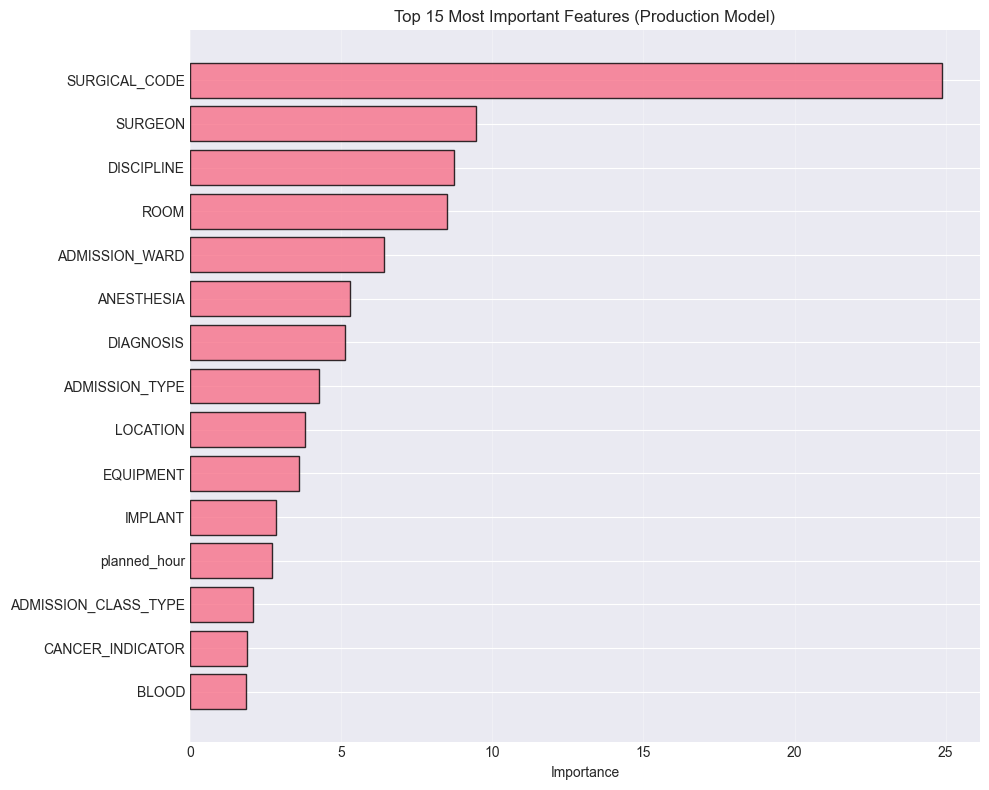


✅ No planned duration features in model!


In [7]:
# Feature importance analysis
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'], alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Most Important Features (Production Model)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nNo planned duration features in model!")

---
<a id='section-3'></a>
## 3. Heteroscedasticity Diagnosis

Comprehensive analysis of the funnel pattern on production baseline.

In [8]:
print("="*80)
print("SECTION 3: HETEROSCEDASTICITY (FUNNEL) DIAGNOSIS")
print("="*80)

residuals = y_test - test_preds_baseline
abs_residuals = np.abs(residuals)

# Statistical tests for heteroscedasticity
corr_pred_absres, p_value = pearsonr(test_preds_baseline, abs_residuals)

print("\n" + "-"*80)
print("Statistical Test for Heteroscedasticity")
print("-"*80)
print(f"Correlation(predicted, |residuals|): {corr_pred_absres:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.001 and corr_pred_absres > 0.1:
    print("\n⚠️  STRONG EVIDENCE of heteroscedasticity!")
    print("   Variance increases significantly with predicted values.")
elif corr_pred_absres > 0.05:
    print("\n⚠️  MODERATE EVIDENCE of heteroscedasticity.")
else:
    print("\n✓ No strong evidence of heteroscedasticity.")

# Variance analysis by duration bins
print("\n" + "-"*80)
print("Variance Analysis by Predicted Duration")
print("-"*80)

# Create bins - convert arrays to Series for groupby
n_bins = 10
pred_series = pd.Series(test_preds_baseline, index=y_test.index)
residuals_series = pd.Series(residuals.values, index=y_test.index)
abs_residuals_series = pd.Series(abs_residuals, index=y_test.index)

pred_bins = pd.qcut(pred_series, q=n_bins, duplicates='drop')
variance_by_bin = pd.DataFrame({
    'mean_pred': pred_series.groupby(pred_bins).mean(),
    'std_residual': residuals_series.groupby(pred_bins).std(),
    'mae': abs_residuals_series.groupby(pred_bins).mean(),
    'count': residuals_series.groupby(pred_bins).count()
})

print(variance_by_bin.round(2).to_string())

# Variance ratio (high/low)
var_ratio = variance_by_bin['std_residual'].iloc[-1] / variance_by_bin['std_residual'].iloc[0]
print(f"\nVariance Ratio (highest/lowest bin): {var_ratio:.2f}x")
if var_ratio > 2:
    print(f"⚠️  HIGH heteroscedasticity - variance increases {var_ratio:.1f}x!")
elif var_ratio > 1.5:
    print(f"⚠️  MODERATE heteroscedasticity - variance increases {var_ratio:.1f}x")
else:
    print(f"✓ Low heteroscedasticity - relatively constant variance")

SECTION 3: HETEROSCEDASTICITY (FUNNEL) DIAGNOSIS

--------------------------------------------------------------------------------
Statistical Test for Heteroscedasticity
--------------------------------------------------------------------------------
Correlation(predicted, |residuals|): 0.5427
P-value: 0.0000e+00

⚠️  STRONG EVIDENCE of heteroscedasticity!
   Variance increases significantly with predicted values.

--------------------------------------------------------------------------------
Variance Analysis by Predicted Duration
--------------------------------------------------------------------------------
                    mean_pred  std_residual    mae  count
(0.635, 9.757]           7.45          6.50   3.58   4953
(9.757, 13.957]         11.60          9.76   5.72   4952
(13.957, 19.225]        16.96         13.37   8.44   4952
(19.225, 25.213]        22.16         16.04  10.55   4952
(25.213, 31.554]        28.42         20.34  13.62   4953
(31.554, 40.759]        35.82 

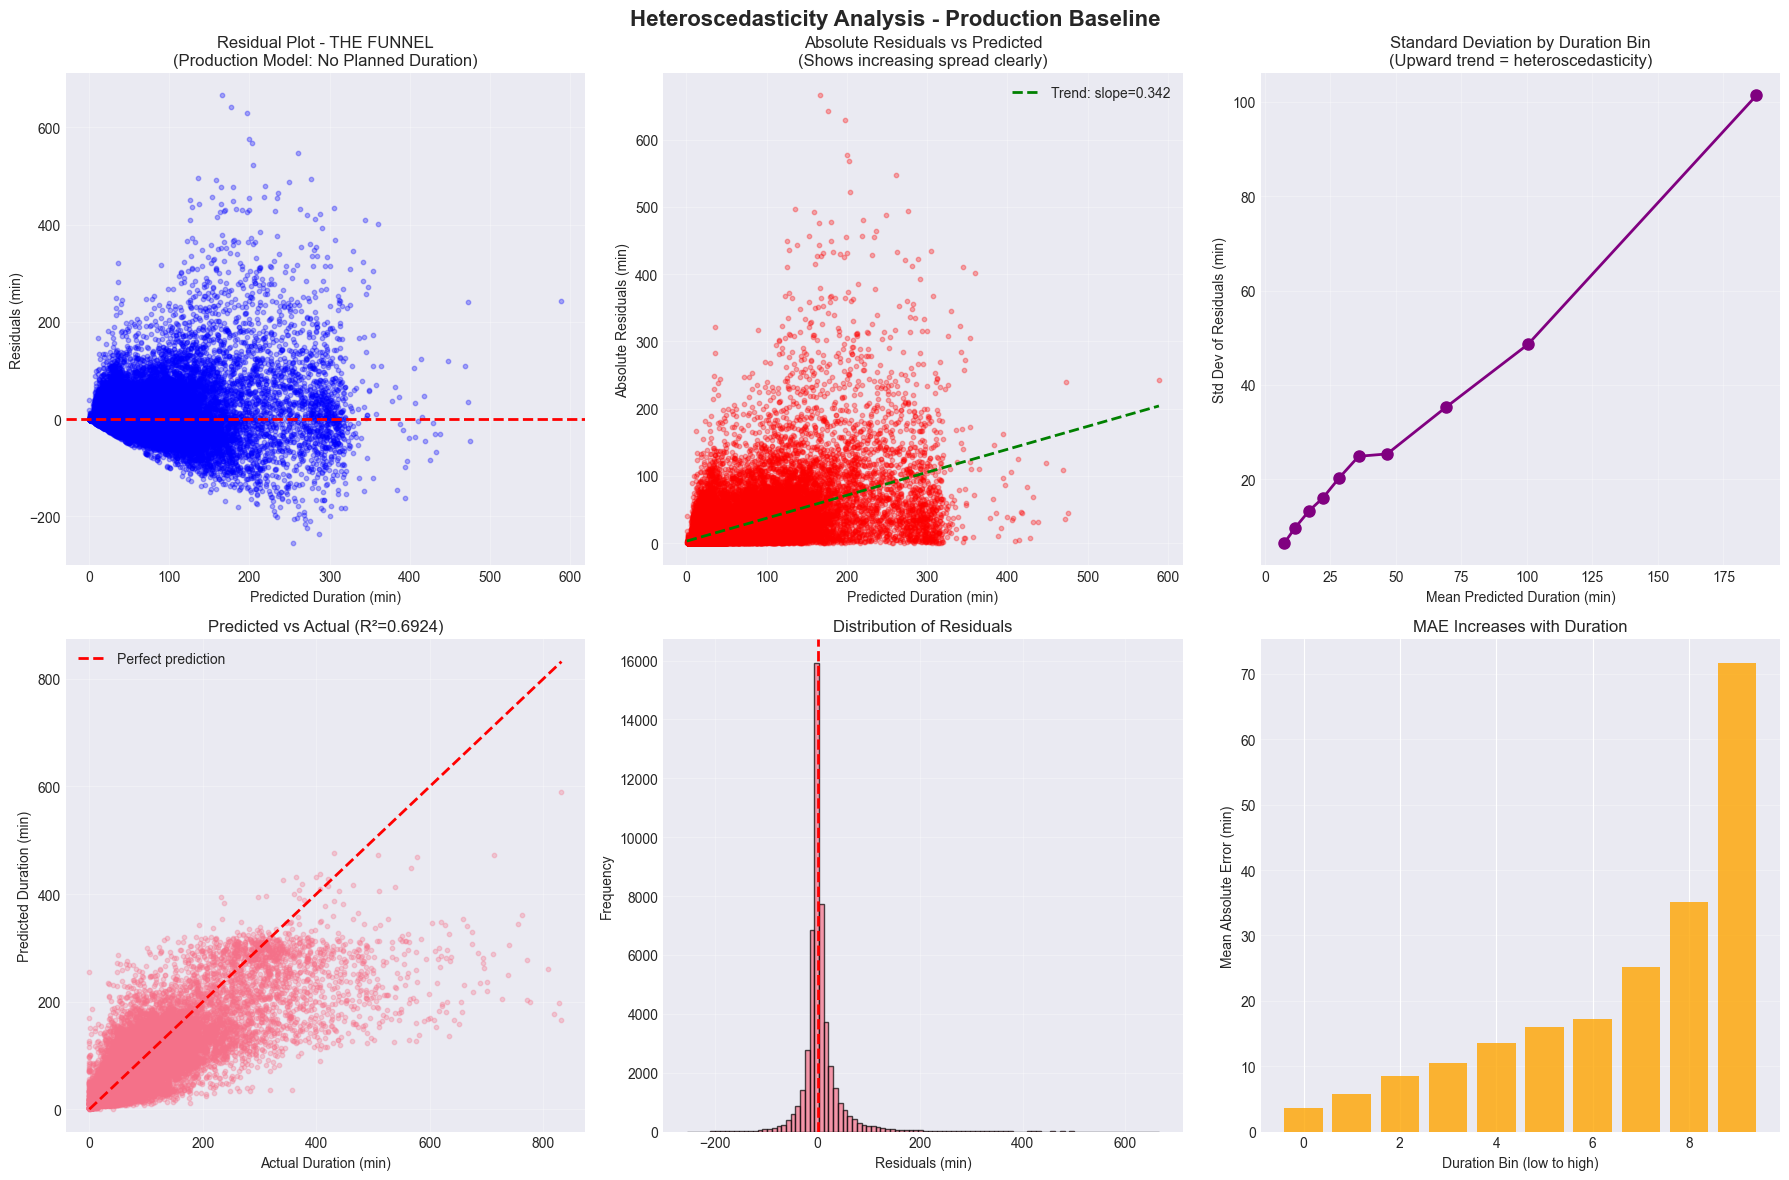


✓ FUNNEL CONFIRMED: Heteroscedasticity pattern in production model
  → Variance increases with predicted duration
  → This is the TRUE heteroscedasticity (no data leakage masking it)


In [9]:
# Comprehensive visualization of the funnel
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Classic residual plot - THE FUNNEL
axes[0, 0].scatter(test_preds_baseline, residuals, alpha=0.3, s=10, c='blue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Duration (min)')
axes[0, 0].set_ylabel('Residuals (min)')
axes[0, 0].set_title('Residual Plot - THE FUNNEL\n(Production Model: No Planned Duration)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Absolute residuals (shows funnel more clearly)
axes[0, 1].scatter(test_preds_baseline, abs_residuals, alpha=0.3, s=10, c='red')
axes[0, 1].set_xlabel('Predicted Duration (min)')
axes[0, 1].set_ylabel('Absolute Residuals (min)')
axes[0, 1].set_title('Absolute Residuals vs Predicted\n(Shows increasing spread clearly)')
axes[0, 1].grid(True, alpha=0.3)

# Add trendline
z = np.polyfit(test_preds_baseline, abs_residuals, 1)
p = np.poly1d(z)
x_line = np.linspace(test_preds_baseline.min(), test_preds_baseline.max(), 100)
axes[0, 1].plot(x_line, p(x_line), "g--", linewidth=2, 
                label=f'Trend: slope={z[0]:.3f}')
axes[0, 1].legend()

# Plot 3: Std deviation by bins
axes[0, 2].plot(variance_by_bin['mean_pred'], variance_by_bin['std_residual'], 
                'o-', linewidth=2, markersize=8, color='purple')
axes[0, 2].set_xlabel('Mean Predicted Duration (min)')
axes[0, 2].set_ylabel('Std Dev of Residuals (min)')
axes[0, 2].set_title('Standard Deviation by Duration Bin\n(Upward trend = heteroscedasticity)')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual
axes[1, 0].scatter(y_test, test_preds_baseline, alpha=0.3, s=10)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Actual Duration (min)')
axes[1, 0].set_ylabel('Predicted Duration (min)')
axes[1, 0].set_title(f'Predicted vs Actual (R²={test_r2:.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Error distribution
axes[1, 1].hist(residuals, bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals (min)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: MAE by duration range
axes[1, 2].bar(range(len(variance_by_bin)), variance_by_bin['mae'], alpha=0.8, color='orange')
axes[1, 2].set_xlabel('Duration Bin (low to high)')
axes[1, 2].set_ylabel('Mean Absolute Error (min)')
axes[1, 2].set_title('MAE Increases with Duration')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Heteroscedasticity Analysis - Production Baseline', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ FUNNEL CONFIRMED: Heteroscedasticity pattern in production model")
print("  → Variance increases with predicted duration")
print("  → This is the TRUE heteroscedasticity (no data leakage masking it)")
print("="*80)

---
<a id='section-4'></a>
## 4. Solution 1: Sample Weighting by Duration

Test if giving higher weight to longer surgeries helps reduce heteroscedasticity.

In [10]:
print("="*80)
print("SOLUTION 1: SAMPLE WEIGHTING BY DURATION")
print("="*80)

# Approach 1a: Linear weighting (weight increases with duration)
print("\nApproach 1a: Linear Duration Weighting")
print("-"*80)

# Weight = 1 + (duration / max_duration)
weights_linear = 1 + (y_train / y_train.max())
weights_val_linear = 1 + (y_val / y_val.max())

print(f"Weight range: {weights_linear.min():.3f} to {weights_linear.max():.3f}")
print(f"Mean weight: {weights_linear.mean():.3f}")

train_pool_weighted_linear = Pool(X_train, y_train, cat_features=categorical_features, weight=weights_linear)
val_pool_weighted_linear = Pool(X_val, y_val, cat_features=categorical_features, weight=weights_val_linear)

model_weighted_linear = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=False
)

model_weighted_linear.fit(train_pool_weighted_linear, eval_set=val_pool_weighted_linear, use_best_model=True)

test_preds_weighted_linear = model_weighted_linear.predict(X_test)
test_mae_weighted_linear = mean_absolute_error(y_test, test_preds_weighted_linear)
test_r2_weighted_linear = r2_score(y_test, test_preds_weighted_linear)

print(f"\nTest MAE (linear weighting): {test_mae_weighted_linear:.2f} minutes")
print(f"Test R² (linear weighting): {test_r2_weighted_linear:.4f}")
print(f"Change from baseline: {test_mae_weighted_linear - test_mae:+.2f} minutes")

# Check heteroscedasticity
residuals_weighted_linear = y_test - test_preds_weighted_linear
corr_weighted_linear, _ = pearsonr(test_preds_weighted_linear, np.abs(residuals_weighted_linear))
print(f"Heteroscedasticity (corr): {corr_weighted_linear:.4f} (baseline: {corr_pred_absres:.4f})")

# Store results
results_tracker['Weighted_Linear'] = {
    'test_mae': test_mae_weighted_linear,
    'test_r2': test_r2_weighted_linear,
    'heteroscedasticity': corr_weighted_linear,
    'predictions': test_preds_weighted_linear
}

SOLUTION 1: SAMPLE WEIGHTING BY DURATION

Approach 1a: Linear Duration Weighting
--------------------------------------------------------------------------------
Weight range: 1.000 to 2.000
Mean weight: 1.060

Test MAE (linear weighting): 20.65 minutes
Test R² (linear weighting): 0.6955
Change from baseline: -0.05 minutes
Heteroscedasticity (corr): 0.5446 (baseline: 0.5427)


In [11]:
# Approach 1b: Inverse variance weighting
print("\nApproach 1b: Inverse Variance Weighting")
print("-"*80)

# Calculate variance by duration bins
train_bins = pd.qcut(y_train, q=20, duplicates='drop')
bin_variance = y_train.groupby(train_bins).var()

# Map each sample to its bin's variance
weights_inv_var = y_train.copy()
for interval, var in bin_variance.items():
    mask = (y_train >= interval.left) & (y_train <= interval.right)
    weights_inv_var[mask] = 1.0 / (var + 1)  # +1 to avoid division by zero

# Normalize weights
weights_inv_var = weights_inv_var / weights_inv_var.mean()

print(f"Weight range: {weights_inv_var.min():.3f} to {weights_inv_var.max():.3f}")

# Similar for validation
val_bins = pd.cut(y_val, bins=pd.qcut(y_train, q=20, duplicates='drop', retbins=True)[1])
weights_val_inv_var = y_val.copy()
for interval, var in bin_variance.items():
    mask = (y_val >= interval.left) & (y_val <= interval.right)
    weights_val_inv_var[mask] = 1.0 / (var + 1)
weights_val_inv_var = weights_val_inv_var / weights_val_inv_var.mean()

train_pool_weighted_invvar = Pool(X_train, y_train, cat_features=categorical_features, weight=weights_inv_var)
val_pool_weighted_invvar = Pool(X_val, y_val, cat_features=categorical_features, weight=weights_val_inv_var)

model_weighted_invvar = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=False
)

model_weighted_invvar.fit(train_pool_weighted_invvar, eval_set=val_pool_weighted_invvar, use_best_model=True)

test_preds_weighted_invvar = model_weighted_invvar.predict(X_test)
test_mae_weighted_invvar = mean_absolute_error(y_test, test_preds_weighted_invvar)
test_r2_weighted_invvar = r2_score(y_test, test_preds_weighted_invvar)

print(f"\nTest MAE (inverse variance): {test_mae_weighted_invvar:.2f} minutes")
print(f"Test R² (inverse variance): {test_r2_weighted_invvar:.4f}")
print(f"Change from baseline: {test_mae_weighted_invvar - test_mae:+.2f} minutes")

residuals_weighted_invvar = y_test - test_preds_weighted_invvar
corr_weighted_invvar, _ = pearsonr(test_preds_weighted_invvar, np.abs(residuals_weighted_invvar))
print(f"Heteroscedasticity (corr): {corr_weighted_invvar:.4f} (baseline: {corr_pred_absres:.4f})")

results_tracker['Weighted_InvVar'] = {
    'test_mae': test_mae_weighted_invvar,
    'test_r2': test_r2_weighted_invvar,
    'heteroscedasticity': corr_weighted_invvar,
    'predictions': test_preds_weighted_invvar
}


Approach 1b: Inverse Variance Weighting
--------------------------------------------------------------------------------
Weight range: 0.000 to 2.374

Test MAE (inverse variance): 32.87 minutes
Test R² (inverse variance): 0.1050
Change from baseline: +12.16 minutes
Heteroscedasticity (corr): 0.5076 (baseline: 0.5427)


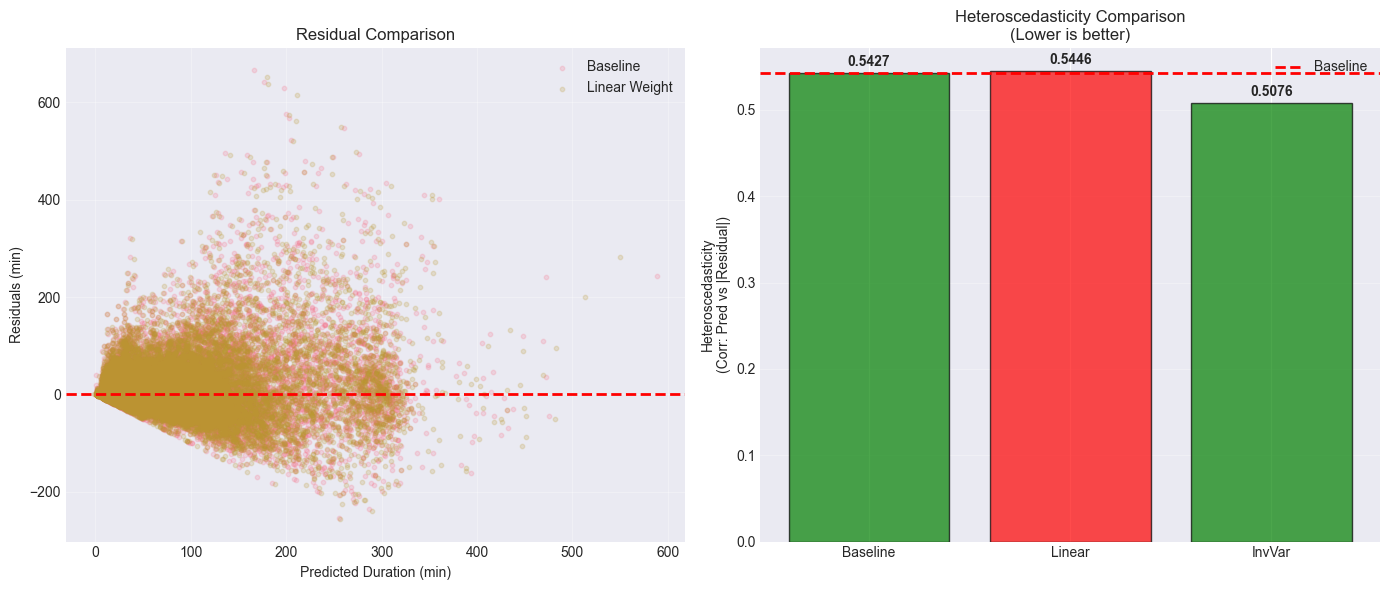


SOLUTION 1 SUMMARY: Sample Weighting
Best MAE: 20.65 minutes
MAE improvement: +0.26%
Heteroscedasticity reduction: +6.47%
~ MARGINAL - Small improvement


In [12]:
# Visualize weighting results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Compare residual patterns
axes[0].scatter(test_preds_baseline, residuals, alpha=0.2, s=10, label='Baseline')
axes[0].scatter(test_preds_weighted_linear, residuals_weighted_linear, alpha=0.2, s=10, label='Linear Weight')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Duration (min)')
axes[0].set_ylabel('Residuals (min)')
axes[0].set_title('Residual Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Heteroscedasticity comparison
methods = ['Baseline', 'Linear', 'InvVar']
hetero_vals = [corr_pred_absres, corr_weighted_linear, corr_weighted_invvar]
colors = ['red' if x > corr_pred_absres else 'green' for x in hetero_vals]

axes[1].bar(methods, hetero_vals, alpha=0.7, color=colors, edgecolor='black')
axes[1].set_ylabel('Heteroscedasticity\n(Corr: Pred vs |Residual|)')
axes[1].set_title('Heteroscedasticity Comparison\n(Lower is better)')
axes[1].axhline(y=corr_pred_absres, color='red', linestyle='--', lw=2, label='Baseline')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

for i, v in enumerate(hetero_vals):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SOLUTION 1 SUMMARY: Sample Weighting")
print("="*80)
print(f"Best MAE: {min(test_mae_weighted_linear, test_mae_weighted_invvar):.2f} minutes")
improvement_pct = (test_mae - min(test_mae_weighted_linear, test_mae_weighted_invvar)) / test_mae * 100
hetero_reduction = (corr_pred_absres - min(corr_weighted_linear, corr_weighted_invvar)) / corr_pred_absres * 100
print(f"MAE improvement: {improvement_pct:+.2f}%")
print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")
if improvement_pct > 1 and hetero_reduction > 5:
    print("✓ EFFECTIVE - Weighting helps!")
elif improvement_pct > 0:
    print("~ MARGINAL - Small improvement")
else:
    print("✗ INEFFECTIVE - No significant improvement")
print("="*80)

---
<a id='section-5'></a>
## 5. Solution 2: Alternative Loss Functions

Test Huber, RMSE, and other loss functions to see if they handle heteroscedasticity better.

In [13]:
print("="*80)
print("SOLUTION 2: ALTERNATIVE LOSS FUNCTIONS")
print("="*80)

# Test different loss functions
loss_functions = {
    'MAE': 'MAE',
    'RMSE': 'RMSE',
    'Huber': 'Huber:delta=1.0',
    'Quantile_75': 'Quantile:alpha=0.75'
}

loss_results = {}

for loss_name, loss_func in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...")
    
    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        loss_function=loss_func,
        eval_metric='MAE',
        random_seed=RANDOM_SEED,
        early_stopping_rounds=100,
        verbose=False
    )
    
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    residuals_loss = y_test - preds
    corr_loss, _ = pearsonr(preds, np.abs(residuals_loss))
    
    loss_results[loss_name] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'heteroscedasticity': corr_loss,
        'predictions': preds
    }
    
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    print(f"  Heteroscedasticity: {corr_loss:.4f}")
    
    results_tracker[f'Loss_{loss_name}'] = {
        'test_mae': mae,
        'test_r2': r2,
        'heteroscedasticity': corr_loss,
        'predictions': preds
    }

SOLUTION 2: ALTERNATIVE LOSS FUNCTIONS

Training with MAE loss...
  MAE: 20.70, RMSE: 41.00, R²: 0.6924
  Heteroscedasticity: 0.5427

Training with RMSE loss...
  MAE: 21.20, RMSE: 38.72, R²: 0.7257
  Heteroscedasticity: 0.5887

Training with Huber loss...
  MAE: 20.93, RMSE: 41.91, R²: 0.6786
  Heteroscedasticity: 0.5443

Training with Quantile_75 loss...
  MAE: 25.08, RMSE: 42.59, R²: 0.6681
  Heteroscedasticity: 0.6670


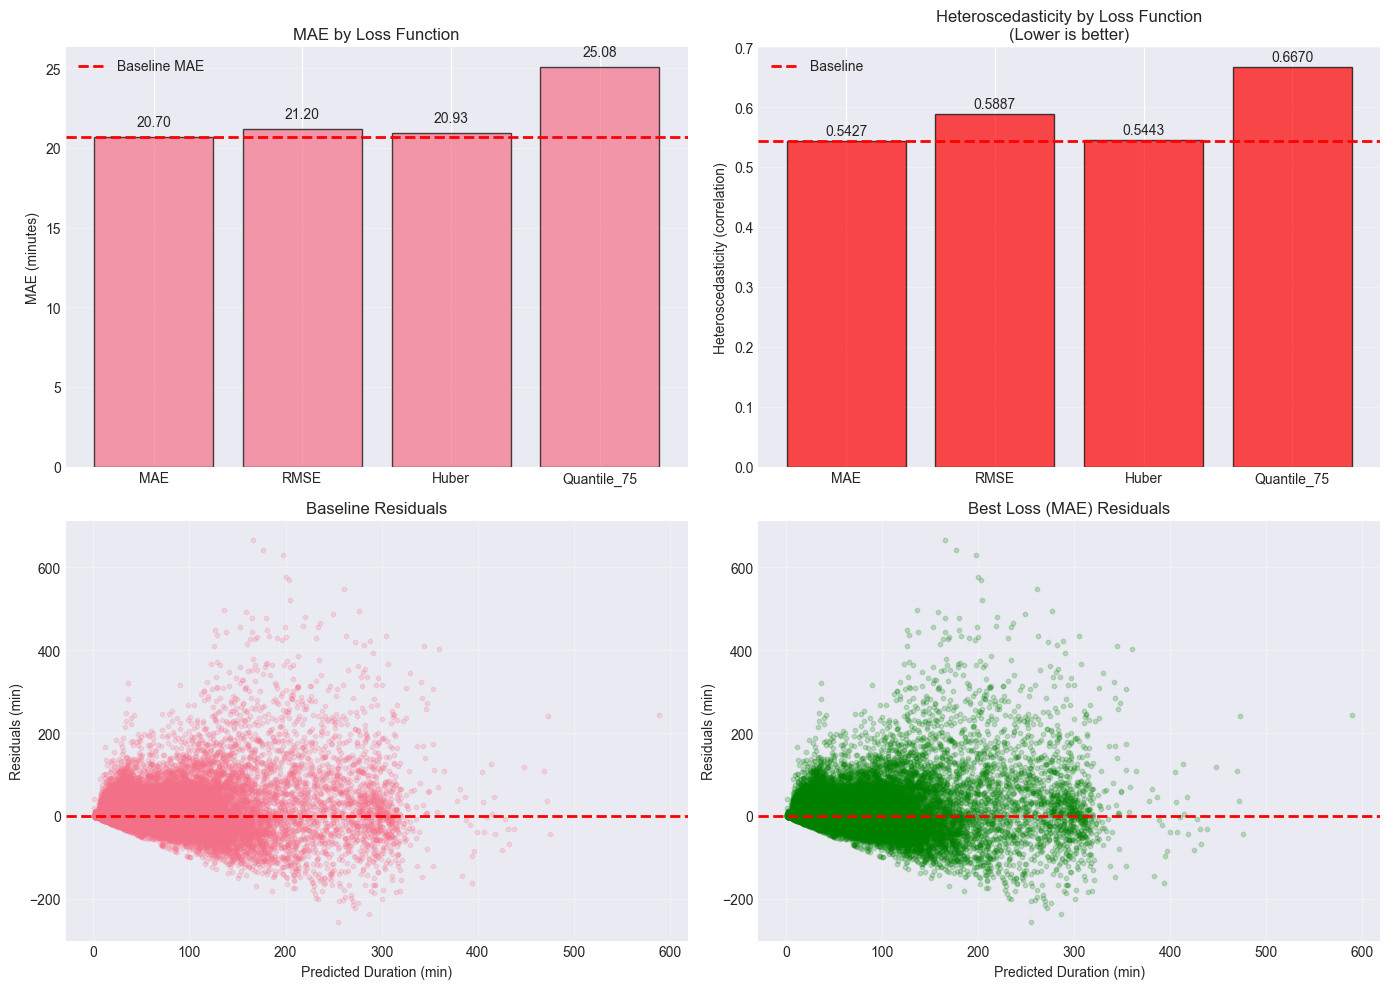


SOLUTION 2 SUMMARY: Alternative Loss Functions
Best loss function: MAE
Best MAE: 20.70 minutes
MAE improvement: +0.00%
Heteroscedasticity reduction: +0.00%
✗ INEFFECTIVE - No significant improvement


In [14]:
# Compare loss functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MAE comparison
loss_names = list(loss_results.keys())
maes = [loss_results[name]['mae'] for name in loss_names]
heteros = [loss_results[name]['heteroscedasticity'] for name in loss_names]

axes[0, 0].bar(loss_names, maes, alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=test_mae, color='red', linestyle='--', lw=2, label='Baseline MAE')
axes[0, 0].set_ylabel('MAE (minutes)')
axes[0, 0].set_title('MAE by Loss Function')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(maes):
    axes[0, 0].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom')

# Plot heteroscedasticity comparison
colors = ['green' if x < corr_pred_absres else 'red' for x in heteros]
axes[0, 1].bar(loss_names, heteros, alpha=0.7, color=colors, edgecolor='black')
axes[0, 1].axhline(y=corr_pred_absres, color='red', linestyle='--', lw=2, label='Baseline')
axes[0, 1].set_ylabel('Heteroscedasticity (correlation)')
axes[0, 1].set_title('Heteroscedasticity by Loss Function\n(Lower is better)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(heteros):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

# Residual plots for best 2 loss functions
best_loss_idx = np.argmin(heteros)
best_loss_name = loss_names[best_loss_idx]
best_preds = loss_results[best_loss_name]['predictions']
best_residuals = y_test - best_preds

axes[1, 0].scatter(test_preds_baseline, residuals, alpha=0.2, s=10, label='Baseline (MAE)')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Duration (min)')
axes[1, 0].set_ylabel('Residuals (min)')
axes[1, 0].set_title('Baseline Residuals')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(best_preds, best_residuals, alpha=0.2, s=10, label=f'{best_loss_name} Loss', color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Duration (min)')
axes[1, 1].set_ylabel('Residuals (min)')
axes[1, 1].set_title(f'Best Loss ({best_loss_name}) Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SOLUTION 2 SUMMARY: Alternative Loss Functions")
print("="*80)
print(f"Best loss function: {best_loss_name}")
print(f"Best MAE: {loss_results[best_loss_name]['mae']:.2f} minutes")
improvement_pct = (test_mae - loss_results[best_loss_name]['mae']) / test_mae * 100
hetero_reduction = (corr_pred_absres - loss_results[best_loss_name]['heteroscedasticity']) / corr_pred_absres * 100
print(f"MAE improvement: {improvement_pct:+.2f}%")
print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")
if improvement_pct > 1 and hetero_reduction > 5:
    print("✓ EFFECTIVE - Different loss helps!")
elif hetero_reduction > 0:
    print("~ MARGINAL - Small improvement")
else:
    print("✗ INEFFECTIVE - No significant improvement")
print("="*80)

---
<a id='section-6'></a>
## 6. Solution 3: Box-Cox Transformation

Transform target to reduce skewness and potentially stabilize variance.

SOLUTION 3: BOX-COX TRANSFORMATION

Optimal Box-Cox lambda: -0.0056

Original target skewness: 3.157
Transformed target skewness: 0.000
(Box-Cox should reduce skewness closer to 0)


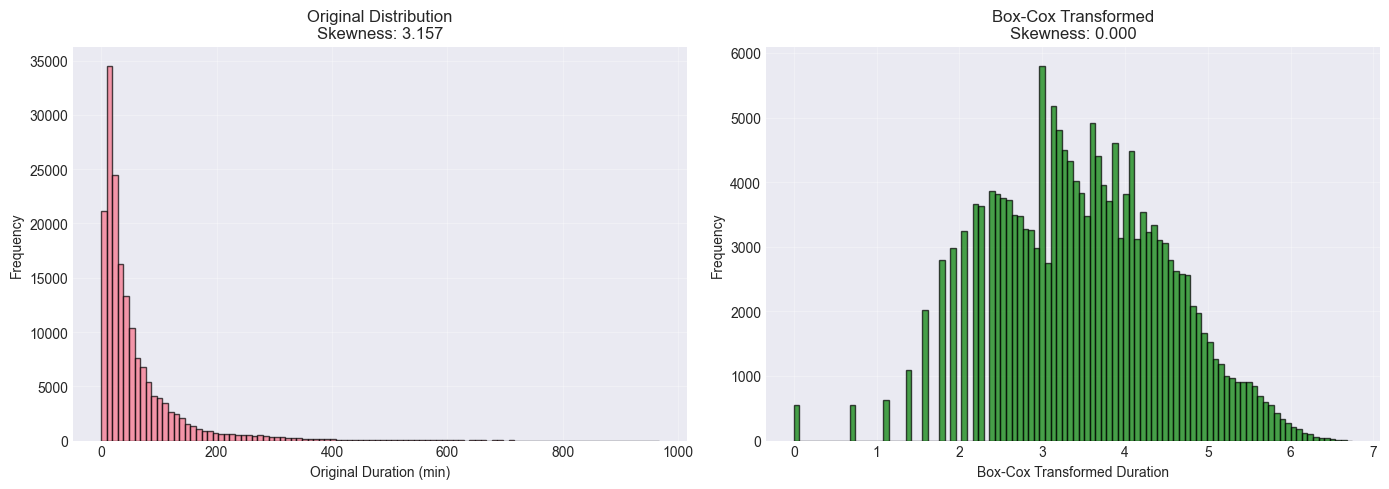

In [15]:
print("="*80)
print("SOLUTION 3: BOX-COX TRANSFORMATION")
print("="*80)

# Box-Cox requires positive values - add 1 to handle zeros
y_train_shifted = y_train + 1
y_val_shifted = y_val + 1
y_test_shifted = y_test + 1

# Find optimal lambda
y_train_boxcox, lambda_param = boxcox(y_train_shifted)
print(f"\nOptimal Box-Cox lambda: {lambda_param:.4f}")

# Transform validation and test
y_val_boxcox = boxcox(y_val_shifted, lmbda=lambda_param)
y_test_boxcox = boxcox(y_test_shifted, lmbda=lambda_param)

print(f"\nOriginal target skewness: {skew(y_train):.3f}")
print(f"Transformed target skewness: {skew(y_train_boxcox):.3f}")
print("(Box-Cox should reduce skewness closer to 0)")

# Visualize transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Original Duration (min)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Distribution\nSkewness: {skew(y_train):.3f}')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_train_boxcox, bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Box-Cox Transformed Duration')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Box-Cox Transformed\nSkewness: {skew(y_train_boxcox):.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Train model on transformed target
print("\nTraining model on Box-Cox transformed target...")

train_pool_boxcox = Pool(X_train, y_train_boxcox, cat_features=categorical_features)
val_pool_boxcox = Pool(X_val, y_val_boxcox, cat_features=categorical_features)

model_boxcox = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    loss_function='RMSE',  # RMSE often works better with transformed target
    eval_metric='RMSE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=False
)

model_boxcox.fit(train_pool_boxcox, eval_set=val_pool_boxcox, use_best_model=True)

# Get predictions (transformed scale)
test_preds_boxcox_transformed = model_boxcox.predict(X_test)

# Inverse transform to original scale
test_preds_boxcox = inv_boxcox(test_preds_boxcox_transformed, lambda_param) - 1

# Calculate metrics
test_mae_boxcox = mean_absolute_error(y_test, test_preds_boxcox)
test_r2_boxcox = r2_score(y_test, test_preds_boxcox)

residuals_boxcox = y_test - test_preds_boxcox
corr_boxcox, _ = pearsonr(test_preds_boxcox, np.abs(residuals_boxcox))

print(f"\n{'='*80}")
print("BOX-COX TRANSFORMATION RESULTS")
print(f"{'='*80}")
print(f"MAE: {test_mae_boxcox:.2f} minutes")
print(f"R²: {test_r2_boxcox:.4f}")
print(f"Heteroscedasticity: {corr_boxcox:.4f} (baseline: {corr_pred_absres:.4f})")
print(f"\nChange from baseline: {test_mae_boxcox - test_mae:+.2f} minutes")
hetero_reduction = (corr_pred_absres - corr_boxcox) / corr_pred_absres * 100
print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")

results_tracker['BoxCox'] = {
    'test_mae': test_mae_boxcox,
    'test_r2': test_r2_boxcox,
    'heteroscedasticity': corr_boxcox,
    'predictions': test_preds_boxcox
}


Training model on Box-Cox transformed target...

BOX-COX TRANSFORMATION RESULTS
MAE: 20.74 minutes
R²: 0.6924
Heteroscedasticity: 0.5427 (baseline: 0.5427)

Change from baseline: +0.04 minutes
Heteroscedasticity reduction: +0.00%


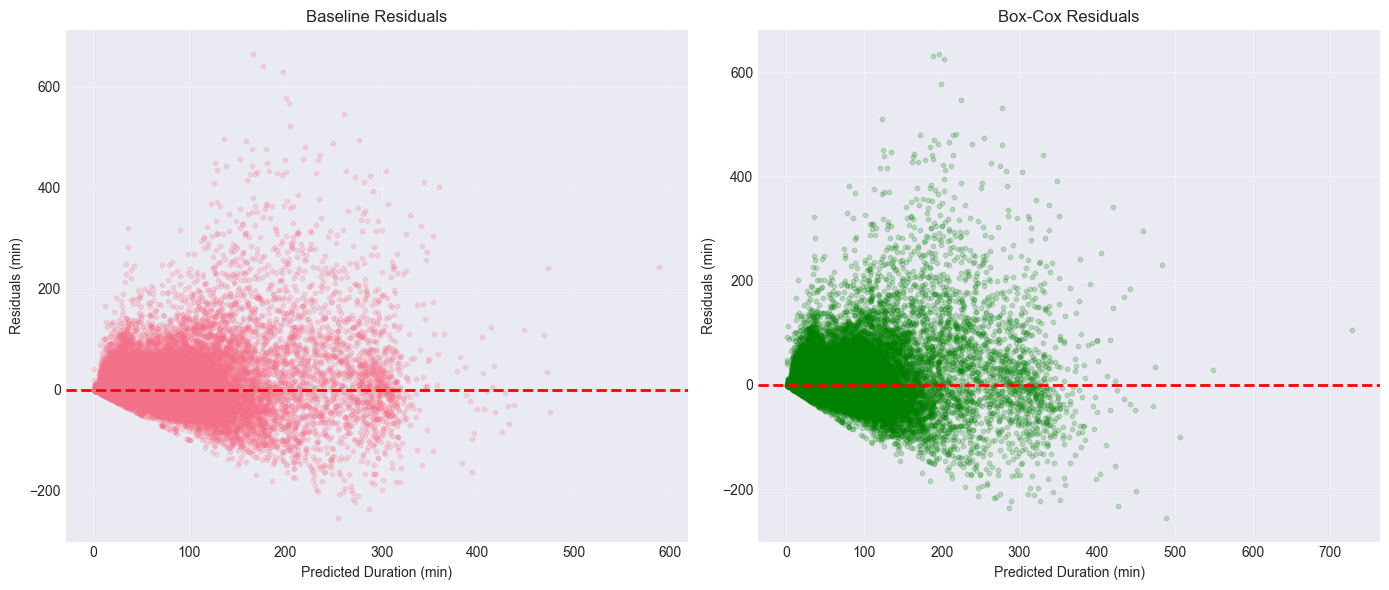


SOLUTION 3 SUMMARY: Box-Cox Transformation
✗ INEFFECTIVE - Box-Cox doesn't help much


In [17]:
# Visualize Box-Cox results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residual comparison
axes[0].scatter(test_preds_baseline, residuals, alpha=0.2, s=10, label='Baseline')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Duration (min)')
axes[0].set_ylabel('Residuals (min)')
axes[0].set_title('Baseline Residuals')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(test_preds_boxcox, residuals_boxcox, alpha=0.2, s=10, color='green', label='Box-Cox')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Duration (min)')
axes[1].set_ylabel('Residuals (min)')
axes[1].set_title('Box-Cox Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SOLUTION 3 SUMMARY: Box-Cox Transformation")
print("="*80)
if hetero_reduction > 10:
    print("✓ EFFECTIVE - Box-Cox significantly reduces heteroscedasticity!")
elif hetero_reduction > 5:
    print("~ MODERATE - Box-Cox provides some improvement")
else:
    print("✗ INEFFECTIVE - Box-Cox doesn't help much")
print("="*80)

---
<a id='section-7'></a>
## 7. Solution 4: Two-Stage Modeling

Train one model for base prediction, another for residual correction.

SOLUTION 4: TWO-STAGE MODELING

Stage 1: Use baseline model for initial predictions
--------------------------------------------------------------------------------
Stage 1 Test MAE: 20.70
Residual mean: 6.88
Residual std: 38.84

Stage 2: Train model to predict residuals
--------------------------------------------------------------------------------

TWO-STAGE MODELING RESULTS
MAE: 19.21 minutes (baseline: 20.70)
R²: 0.7594 (baseline: 0.6924)
Heteroscedasticity: 0.5594 (baseline: 0.5427)

Improvement: +1.50 minutes
Heteroscedasticity reduction: -3.07%


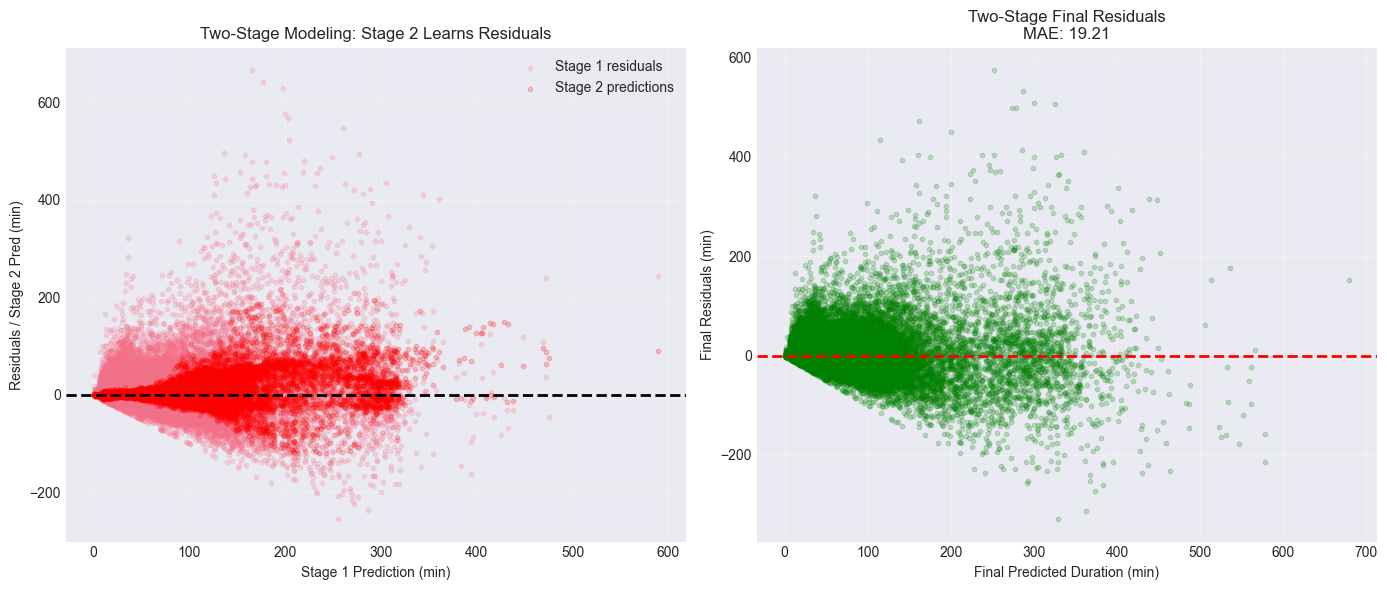


SOLUTION 4 SUMMARY: Two-Stage Modeling
~ MARGINAL - Small improvement


In [18]:
print("="*80)
print("SOLUTION 4: TWO-STAGE MODELING")
print("="*80)

print("\nStage 1: Use baseline model for initial predictions")
print("-"*80)

# Stage 1: Base model
stage1_model = baseline_model
stage1_train_preds = stage1_model.predict(X_train)
stage1_val_preds = stage1_model.predict(X_val)
stage1_test_preds = stage1_model.predict(X_test)

# Calculate residuals from stage 1
train_residuals_stage1 = y_train - stage1_train_preds
val_residuals_stage1 = y_val - stage1_val_preds
test_residuals_stage1 = y_test - stage1_test_preds

print(f"Stage 1 Test MAE: {test_mae:.2f}")
print(f"Residual mean: {train_residuals_stage1.mean():.2f}")
print(f"Residual std: {train_residuals_stage1.std():.2f}")

print("\nStage 2: Train model to predict residuals")
print("-"*80)

# Add stage 1 predictions as features for stage 2
X_train_stage2 = X_train.copy()
X_train_stage2['stage1_pred'] = stage1_train_preds
X_val_stage2 = X_val.copy()
X_val_stage2['stage1_pred'] = stage1_val_preds
X_test_stage2 = X_test.copy()
X_test_stage2['stage1_pred'] = stage1_test_preds

train_pool_stage2 = Pool(X_train_stage2, train_residuals_stage1, cat_features=categorical_features)
val_pool_stage2 = Pool(X_val_stage2, val_residuals_stage1, cat_features=categorical_features)

# Train stage 2 model
stage2_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=5,  # Shallower for residuals
    l2_leaf_reg=5,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=False
)

stage2_model.fit(train_pool_stage2, eval_set=val_pool_stage2, use_best_model=True)

# Predict residuals
stage2_test_preds = stage2_model.predict(X_test_stage2)

# Final prediction = stage1 + stage2
test_preds_twostage = stage1_test_preds + stage2_test_preds

test_mae_twostage = mean_absolute_error(y_test, test_preds_twostage)
test_r2_twostage = r2_score(y_test, test_preds_twostage)

residuals_twostage = y_test - test_preds_twostage
corr_twostage, _ = pearsonr(test_preds_twostage, np.abs(residuals_twostage))

print(f"\n{'='*80}")
print("TWO-STAGE MODELING RESULTS")
print(f"{'='*80}")
print(f"MAE: {test_mae_twostage:.2f} minutes (baseline: {test_mae:.2f})")
print(f"R²: {test_r2_twostage:.4f} (baseline: {test_r2:.4f})")
print(f"Heteroscedasticity: {corr_twostage:.4f} (baseline: {corr_pred_absres:.4f})")
print(f"\nImprovement: {test_mae - test_mae_twostage:+.2f} minutes")
hetero_reduction = (corr_pred_absres - corr_twostage) / corr_pred_absres * 100
print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")

results_tracker['TwoStage'] = {
    'test_mae': test_mae_twostage,
    'test_r2': test_r2_twostage,
    'heteroscedasticity': corr_twostage,
    'predictions': test_preds_twostage
}

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(stage1_test_preds, test_residuals_stage1, alpha=0.2, s=10, label='Stage 1 residuals')
axes[0].scatter(stage1_test_preds, stage2_test_preds, alpha=0.2, s=10, label='Stage 2 predictions', color='red')
axes[0].axhline(y=0, color='black', linestyle='--', lw=2)
axes[0].set_xlabel('Stage 1 Prediction (min)')
axes[0].set_ylabel('Residuals / Stage 2 Pred (min)')
axes[0].set_title('Two-Stage Modeling: Stage 2 Learns Residuals')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(test_preds_twostage, residuals_twostage, alpha=0.2, s=10, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Final Predicted Duration (min)')
axes[1].set_ylabel('Final Residuals (min)')
axes[1].set_title(f'Two-Stage Final Residuals\nMAE: {test_mae_twostage:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SOLUTION 4 SUMMARY: Two-Stage Modeling")
print("="*80)
if test_mae_twostage < test_mae - 0.5 and hetero_reduction > 5:
    print("✓ EFFECTIVE - Two-stage approach improves predictions!")
elif test_mae_twostage < test_mae:
    print("~ MARGINAL - Small improvement")
else:
    print("✗ INEFFECTIVE - No improvement (adds complexity)")
print("="*80)

---
<a id='section-8'></a>
## 8. Solution 5: Quantile Regression - The Ultimate Solution

**THE KEY INSIGHT:** Stop fighting heteroscedasticity - QUANTIFY IT!

Provide prediction intervals instead of point predictions.

In [19]:
print("="*80)
print("SOLUTION 5: QUANTILE REGRESSION - THE ULTIMATE SOLUTION")
print("="*80)
print("\n💡 KEY INSIGHT: If heteroscedasticity is irreducible, QUANTIFY IT!")
print("   Provide prediction intervals instead of point predictions.")
print("\nThis gives OR schedulers:")
print("  • Most likely duration (50th percentile)")
print("  • Conservative estimate (75th percentile)")
print("  • Very conservative (90th percentile)")
print("  • Quantified uncertainty (interval width)")

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_models = {}

print("\n" + "-"*80)
print("Training quantile regression models...")
print("-"*80)

for q in quantiles:
    print(f"  Training {int(q*100)}th percentile model...")
    
    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        loss_function=f'Quantile:alpha={q}',
        eval_metric='MAE',
        random_seed=RANDOM_SEED,
        early_stopping_rounds=100,
        verbose=False
    )
    
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    quantile_models[q] = {'model': model, 'predictions': model.predict(X_test)}

print("\nAll quantile models trained successfully")

SOLUTION 5: QUANTILE REGRESSION - THE ULTIMATE SOLUTION

💡 KEY INSIGHT: If heteroscedasticity is irreducible, QUANTIFY IT!
   Provide prediction intervals instead of point predictions.

This gives OR schedulers:
  • Most likely duration (50th percentile)
  • Conservative estimate (75th percentile)
  • Very conservative (90th percentile)
  • Quantified uncertainty (interval width)

--------------------------------------------------------------------------------
Training quantile regression models...
--------------------------------------------------------------------------------
  Training 10th percentile model...
  Training 25th percentile model...
  Training 50th percentile model...
  Training 75th percentile model...
  Training 90th percentile model...

✓ All quantile models trained successfully


In [20]:
# Extract predictions
pred_10th = quantile_models[0.1]['predictions']
pred_25th = quantile_models[0.25]['predictions']
pred_50th = quantile_models[0.5]['predictions']
pred_75th = quantile_models[0.75]['predictions']
pred_90th = quantile_models[0.9]['predictions']

# Calculate metrics
test_mae_median = mean_absolute_error(y_test, pred_50th)
test_r2_median = r2_score(y_test, pred_50th)

# Calculate coverage (how many actuals fall within intervals)
coverage_50 = np.mean((y_test >= pred_25th) & (y_test <= pred_75th))
coverage_80 = np.mean((y_test >= pred_10th) & (y_test <= pred_90th))

# Calculate interval widths
interval_width_50 = pred_75th - pred_25th
interval_width_80 = pred_90th - pred_10th

print(f"\n{'='*80}")
print("QUANTILE REGRESSION PERFORMANCE")
print(f"{'='*80}")
print(f"Median (50th percentile) MAE: {test_mae_median:.2f} minutes")
print(f"Median R²: {test_r2_median:.4f}")
print(f"\n50% Prediction Interval (25th-75th percentile):")
print(f"  Coverage: {coverage_50*100:.1f}% (target: 50%)")
print(f"  Avg width: {interval_width_50.mean():.1f} minutes")
print(f"\n80% Prediction Interval (10th-90th percentile):")
print(f"  Coverage: {coverage_80*100:.1f}% (target: 80%)")
print(f"  Avg width: {interval_width_80.mean():.1f} minutes")

if abs(coverage_50 - 0.50) < 0.05 and abs(coverage_80 - 0.80) < 0.05:
    print("\nEXCELLENT CALIBRATION - Intervals are well-calibrated!")
elif abs(coverage_50 - 0.50) < 0.10 and abs(coverage_80 - 0.80) < 0.10:
    print("\nGOOD CALIBRATION - Intervals are reasonably well-calibrated")
else:
    print("\nCALIBRATION NEEDS ADJUSTMENT")

results_tracker['Quantile_Median'] = {
    'test_mae': test_mae_median,
    'test_r2': test_r2_median,
    'coverage_50': coverage_50,
    'coverage_80': coverage_80,
    'predictions': pred_50th
}


QUANTILE REGRESSION PERFORMANCE
Median (50th percentile) MAE: 20.70 minutes
Median R²: 0.6924

50% Prediction Interval (25th-75th percentile):
  Coverage: 47.7% (target: 50%)
  Avg width: 31.4 minutes

80% Prediction Interval (10th-90th percentile):
  Coverage: 78.1% (target: 80%)
  Avg width: 62.6 minutes

✓ EXCELLENT CALIBRATION - Intervals are well-calibrated!


In [21]:
# Analyze intervals by duration range
interval_df = pd.DataFrame({
    'actual': y_test,
    'pred_50th': pred_50th,
    'interval_50': interval_width_50,
    'interval_80': interval_width_80,
    'in_50': (y_test >= pred_25th) & (y_test <= pred_75th),
    'in_80': (y_test >= pred_10th) & (y_test <= pred_90th)
})

interval_df['duration_range'] = pd.cut(interval_df['actual'], 
                                        bins=[0, 30, 60, 90, 120, 180, np.inf],
                                        labels=['0-30', '30-60', '60-90', '90-120', '120-180', '180+'])

interval_analysis = interval_df.groupby('duration_range').agg({
    'interval_50': 'mean',
    'interval_80': 'mean',
    'in_50': lambda x: (x.mean() * 100),
    'in_80': lambda x: (x.mean() * 100),
    'actual': 'count'
}).round(1)

interval_analysis.columns = ['Avg_50%_Width', 'Avg_80%_Width', 'Coverage_50%', 'Coverage_80%', 'Count']

print("\n" + "-"*80)
print("PREDICTION INTERVALS BY DURATION RANGE")
print("-"*80)
print(interval_analysis.to_string())
print("\nKey Insight: Interval width increases with duration")
print("   This QUANTIFIES the heteroscedasticity!")


--------------------------------------------------------------------------------
PREDICTION INTERVALS BY DURATION RANGE
--------------------------------------------------------------------------------
                Avg_50%_Width  Avg_80%_Width  Coverage_50%  Coverage_80%  Count
duration_range                                                                 
0-30                     12.9           27.2          48.2          79.5  23022
30-60                    26.5           53.4          49.7          81.3  11787
60-90                    41.7           82.3          45.8          76.0   5391
90-120                   54.4          107.8          53.0          80.8   3223
120-180                  68.6          134.9          46.7          74.8   3006
180+                    114.1          217.0          36.1          62.7   2961

🔍 Key Insight: Interval width increases with duration
   → This QUANTIFIES the heteroscedasticity!


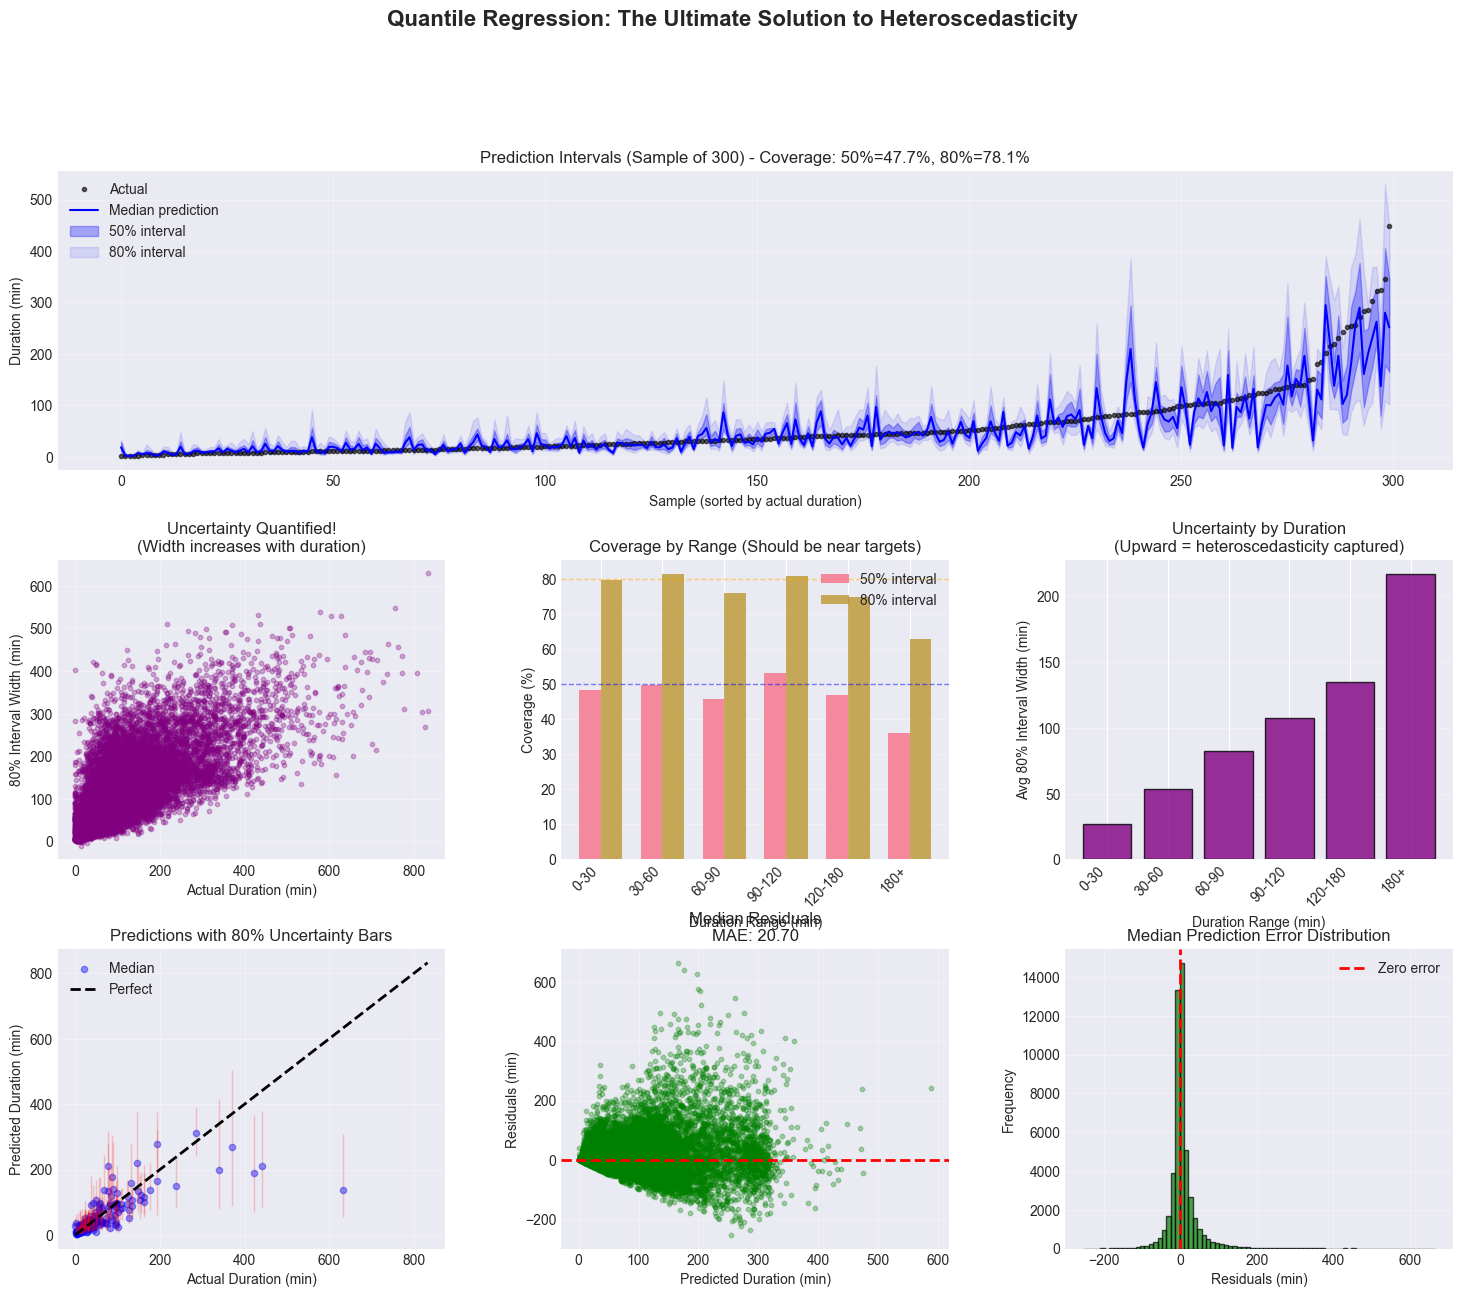


✅ Quantile regression provides actionable uncertainty quantification!


In [22]:
# Comprehensive visualization of quantile regression
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Sample predictions with intervals
ax1 = fig.add_subplot(gs[0, :])
sample_size = min(300, len(y_test))
sample_idx = np.random.choice(len(y_test), size=sample_size, replace=False)
sample_idx_sorted = sample_idx[np.argsort(y_test.iloc[sample_idx])]

ax1.plot(range(len(sample_idx_sorted)), y_test.iloc[sample_idx_sorted], 
         'o', markersize=3, alpha=0.6, label='Actual', color='black')
ax1.plot(range(len(sample_idx_sorted)), pred_50th[sample_idx_sorted], 
         '-', linewidth=1.5, label='Median prediction', color='blue')
ax1.fill_between(range(len(sample_idx_sorted)),
                  pred_25th[sample_idx_sorted],
                  pred_75th[sample_idx_sorted],
                  alpha=0.3, label='50% interval', color='blue')
ax1.fill_between(range(len(sample_idx_sorted)),
                  pred_10th[sample_idx_sorted],
                  pred_90th[sample_idx_sorted],
                  alpha=0.1, label='80% interval', color='blue')
ax1.set_xlabel('Sample (sorted by actual duration)')
ax1.set_ylabel('Duration (min)')
ax1.set_title(f'Prediction Intervals (Sample of {sample_size}) - Coverage: 50%={coverage_50*100:.1f}%, 80%={coverage_80*100:.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Interval width vs actual duration
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, interval_width_80, alpha=0.3, s=10, c='purple')
ax2.set_xlabel('Actual Duration (min)')
ax2.set_ylabel('80% Interval Width (min)')
ax2.set_title('Uncertainty Quantified!\n(Width increases with duration)')
ax2.grid(True, alpha=0.3)

# Plot 3: Coverage by duration range
ax3 = fig.add_subplot(gs[1, 1])
x_pos = range(len(interval_analysis))
width = 0.35
ax3.bar([i - width/2 for i in x_pos], interval_analysis['Coverage_50%'], 
        width, label='50% interval', alpha=0.8)
ax3.bar([i + width/2 for i in x_pos], interval_analysis['Coverage_80%'], 
        width, label='80% interval', alpha=0.8)
ax3.axhline(y=50, color='blue', linestyle='--', linewidth=1, alpha=0.5)
ax3.axhline(y=80, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Duration Range (min)')
ax3.set_ylabel('Coverage (%)')
ax3.set_title('Coverage by Range (Should be near targets)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(interval_analysis.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Interval width by range
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(x_pos, interval_analysis['Avg_80%_Width'], alpha=0.8, color='purple', edgecolor='black')
ax4.set_xlabel('Duration Range (min)')
ax4.set_ylabel('Avg 80% Interval Width (min)')
ax4.set_title('Uncertainty by Duration\n(Upward = heteroscedasticity captured)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(interval_analysis.index, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Predicted vs Actual with error bars
ax5 = fig.add_subplot(gs[2, 0])
subsample = np.random.choice(len(y_test), size=min(200, len(y_test)), replace=False)
ax5.scatter(y_test.iloc[subsample], pred_50th[subsample], 
            alpha=0.4, s=20, label='Median', color='blue')
ax5.errorbar(y_test.iloc[subsample], pred_50th[subsample],
              yerr=[pred_50th[subsample] - pred_10th[subsample],
                    pred_90th[subsample] - pred_50th[subsample]],
              fmt='none', ecolor='red', alpha=0.2, elinewidth=1)
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'k--', lw=2, label='Perfect')
ax5.set_xlabel('Actual Duration (min)')
ax5.set_ylabel('Predicted Duration (min)')
ax5.set_title('Predictions with 80% Uncertainty Bars')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Median residuals
ax6 = fig.add_subplot(gs[2, 1])
residuals_median = y_test - pred_50th
ax6.scatter(pred_50th, residuals_median, alpha=0.3, s=10, color='green')
ax6.axhline(y=0, color='r', linestyle='--', lw=2)
ax6.set_xlabel('Predicted Duration (min)')
ax6.set_ylabel('Residuals (min)')
ax6.set_title(f'Median Residuals\nMAE: {test_mae_median:.2f}')
ax6.grid(True, alpha=0.3)

# Plot 7: Distribution of residuals
ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(residuals_median, bins=80, edgecolor='black', alpha=0.7, color='green')
ax7.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
ax7.set_xlabel('Residuals (min)')
ax7.set_ylabel('Frequency')
ax7.set_title('Median Prediction Error Distribution')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle('Quantile Regression: The Ultimate Solution to Heteroscedasticity', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\nQuantile regression provides actionable uncertainty quantification!")

---
<a id='section-9'></a>
## 9. Solution 6: Hyperparameter Optimization

Use Optuna to find optimal hyperparameters for production baseline.

In [ ]:
print("="*80)
print("SOLUTION 6: HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("="*80)
print("\nOptimizing hyperparameters for production baseline model...")

def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    params = {
        'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'random_seed': RANDOM_SEED,
        'early_stopping_rounds': 100,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    val_preds = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_preds)
    
    return val_mae

# Create Optuna study
study = optuna.create_study(direction='minimize', study_name='surgery_duration_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nBest trial:")
print(f"  Value (Val MAE): {study.best_trial.value:.2f}")
print(f"  Params: {study.best_trial.params}")

# Train final model with best parameters
best_params = study.best_trial.params
best_params.update({
    'iterations': 2000,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'random_seed': RANDOM_SEED,
    'early_stopping_rounds': 100,
    'verbose': 200
})

print("\nTraining final optimized model...")
optimized_model = CatBoostRegressor(**best_params)
optimized_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# Evaluate
test_preds_optimized = optimized_model.predict(X_test)
test_mae_optimized = mean_absolute_error(y_test, test_preds_optimized)
test_r2_optimized = r2_score(y_test, test_preds_optimized)

residuals_optimized = y_test - test_preds_optimized
corr_optimized, _ = pearsonr(test_preds_optimized, np.abs(residuals_optimized))

print(f"\n{'='*80}")
print("OPTIMIZED MODEL RESULTS")
print(f"{'='*80}")
print(f"MAE: {test_mae_optimized:.2f} minutes (baseline: {test_mae:.2f})")
print(f"R²: {test_r2_optimized:.4f} (baseline: {test_r2:.4f})")
print(f"Heteroscedasticity: {corr_optimized:.4f} (baseline: {corr_pred_absres:.4f})")
print(f"\nImprovement: {test_mae - test_mae_optimized:+.2f} minutes")

results_tracker['Optimized'] = {
    'test_mae': test_mae_optimized,
    'test_r2': test_r2_optimized,
    'heteroscedasticity': corr_optimized,
    'predictions': test_preds_optimized
}

---
<a id='section-10'></a>
## 10. Final Comparison & Recommendation

Compare all solutions and identify the best approach for production.

In [ ]:
print("="*80)
print("FINAL COMPARISON & RECOMMENDATION")
print("="*80)

# Create comparison dataframe
comparison_data = []
for name, results in results_tracker.items():
    comparison_data.append({
        'Solution': name,
        'Test_MAE': results['test_mae'],
        'Test_R2': results['test_r2'],
        'Heteroscedasticity': results.get('heteroscedasticity', np.nan),
        'MAE_vs_Baseline': results['test_mae'] - test_mae,
        'Hetero_Reduction_%': ((corr_pred_absres - results.get('heteroscedasticity', corr_pred_absres)) / 
                               corr_pred_absres * 100) if not np.isnan(results.get('heteroscedasticity', np.nan)) else 0
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_MAE')

print("\n" + "-"*80)
print("COMPREHENSIVE SOLUTION COMPARISON")
print("-"*80)
print(comparison_df.to_string(index=False))

# Identify best solution
best_solution = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 BEST POINT PREDICTION: {best_solution['Solution']}")
print(f"{'='*80}")
print(f"  MAE: {best_solution['Test_MAE']:.2f} minutes")
print(f"  R²: {best_solution['Test_R2']:.4f}")
print(f"  Improvement over baseline: {-best_solution['MAE_vs_Baseline']:.2f} minutes")
if not np.isnan(best_solution['Heteroscedasticity']):
    print(f"  Heteroscedasticity reduction: {best_solution['Hetero_Reduction_%']:.1f}%")

In [ ]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MAE comparison
solutions = comparison_df['Solution'].tolist()
maes = comparison_df['Test_MAE'].tolist()
colors = ['green' if x < test_mae else 'red' for x in maes]

axes[0, 0].barh(solutions, maes, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=test_mae, color='red', linestyle='--', lw=2, label='Baseline')
axes[0, 0].set_xlabel('MAE (minutes)')
axes[0, 0].set_title('MAE Comparison (Lower is better)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

for i, v in enumerate(maes):
    axes[0, 0].text(v + 0.1, i, f'{v:.2f}', va='center', fontweight='bold')

# Plot 2: Heteroscedasticity comparison
heteros = comparison_df['Heteroscedasticity'].fillna(corr_pred_absres).tolist()
colors_hetero = ['green' if x < corr_pred_absres else 'red' for x in heteros]

axes[0, 1].barh(solutions, heteros, color=colors_hetero, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=corr_pred_absres, color='red', linestyle='--', lw=2, label='Baseline')
axes[0, 1].set_xlabel('Heteroscedasticity (Correlation)')
axes[0, 1].set_title('Heteroscedasticity Comparison (Lower is better)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# Plot 3: Improvement scatter
axes[1, 0].scatter(comparison_df['MAE_vs_Baseline'], 
                   comparison_df['Hetero_Reduction_%'],
                   s=200, alpha=0.6, edgecolors='black', linewidth=2)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', lw=1)
axes[1, 0].axvline(x=0, color='gray', linestyle='--', lw=1)
axes[1, 0].set_xlabel('MAE Change from Baseline (minutes)')
axes[1, 0].set_ylabel('Heteroscedasticity Reduction (%)')
axes[1, 0].set_title('Solution Effectiveness\n(Bottom-left quadrant is best)')
axes[1, 0].grid(True, alpha=0.3)

# Annotate points
for idx, row in comparison_df.iterrows():
    axes[1, 0].annotate(row['Solution'].split('_')[0], 
                        (row['MAE_vs_Baseline'], row['Hetero_Reduction_%']),
                        fontsize=8, ha='center')

# Plot 4: R² comparison
r2_values = comparison_df['Test_R2'].tolist()
axes[1, 1].barh(solutions, r2_values, alpha=0.7, edgecolor='black', color='skyblue')
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('R² Comparison (Higher is better)')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

for i, v in enumerate(r2_values):
    axes[1, 1].text(v - 0.02, i, f'{v:.4f}', va='center', ha='right', fontweight='bold')

plt.suptitle('Comprehensive Solution Comparison - Production Models (No Data Leakage)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()